In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
inputs = tokenizer(['Hello world', 'Hi how are you'], padding=True, truncation=True,
                  return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 7592, 2088,  102,    0,    0],
       [ 101, 7632, 2129, 2024, 2017,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1]], dtype=int32)>}

# FINETUNING CUSTOM DATASET

In [6]:
df = pd.read_csv("/content/Data_balanced.csv")

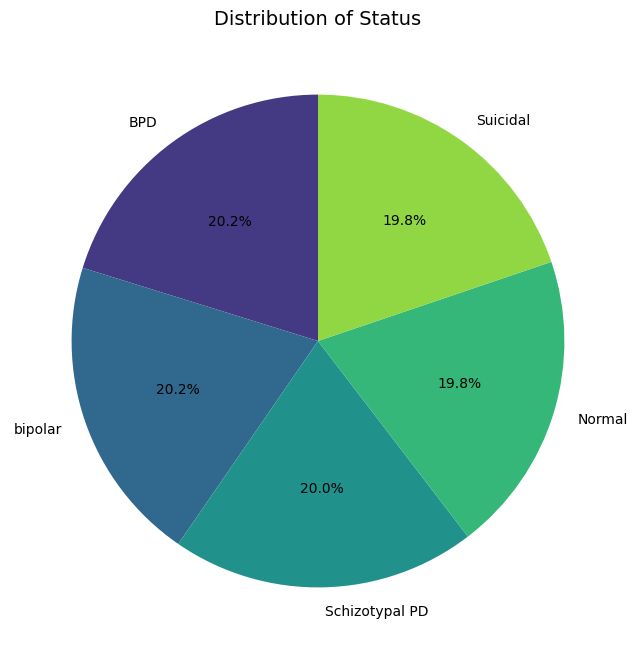

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get value counts
status_counts = df['status'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("viridis", len(status_counts)))

# Title
plt.title("Distribution of Status", fontsize=14)

# Show plot
plt.show()


In [8]:
df.head()

,statement,status
0,Why do racers after the race immediately wear ...,Normal
1,Nugas together from time to time...SD-SMP: at ...,Normal
2,Indihouse why the hell,Normal
3,@JonathanRKnight,Normal
4,[HELP RT] WE FANBASE SHAKE RP! JOIN? FOLLOW FI...,Normal


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24750 entries, 0 to 24749
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  24748 non-null  object
 1   status     24750 non-null  object
dtypes: object(2)
memory usage: 386.8+ KB


In [10]:
df['label'] = pd.factorize(df['status'])[0]

In [11]:
df['label'].unique()

array([0, 1, 2, 3, 4])

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [13]:
# Tokenize the 'statement' column
def tokenize(batch):
    # Convert the 'statement' column to a list and remove None values if present
    statements = [str(s) for s in batch["statement"].tolist() if s is not None]
    # Correct the return value to avoid adding extra dimension.
    encodings = tokenizer(statements, padding=True, truncation=True,
                     return_tensors='tf',  # Ensure tensors are returned
                     max_length=128)  # Limit the sequence length

    # Return a dictionary where each value is a 2D tensor
    # The input shape is now (batch_size, max_length) which is what BERT expects
    # Remove the tf.squeeze operation since the tokenizer handles the dimensions correctly.
    return {key: val for key, val in encodings.items() if key in ['input_ids', 'attention_mask', 'token_type_ids']}

In [14]:
# Tokenize the train and test data
train_encodings = tokenize(train_df)
test_encodings = tokenize(test_df)

In [15]:
train_encodings

{'input_ids': <tf.Tensor: shape=(19800, 128), dtype=int32, numpy=
 array([[  101,  1998,  2043, ...,     0,     0,     0],
        [  101,  4931,  4364, ...,  2936,  1045,   102],
        [  101,  2009,  2074, ...,  2030,  2383,   102],
        ...,
        [  101, 13360, 11057, ...,     0,     0,     0],
        [  101,  2061,  1045, ...,     0,     0,     0],
        [  101,  1056,  2860, ...,  2138,  1997,   102]], dtype=int32)>,
 'token_type_ids': <tf.Tensor: shape=(19800, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(19800, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['label'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df['label'].values))

In [17]:
# Set batch size and shuffle the training set
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(len(train_df)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Build the BERT model for classification
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        x = self.dropout(x)
        return self.fc(x)


In [18]:

# Create classifier
classifier = BERTForClassification(model, num_classes=len(df['label'].unique()))

# Compile the model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [19]:
# Train the model
history = classifier.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

Epoch 1/10
310/310 [==============================] - 561s 2s/step - loss: 1.6009 - accuracy: 0.2858 - val_loss: 1.2876 - val_accuracy: 0.5244
Epoch 2/10
310/310 [==============================] - 513s 2s/step - loss: 1.2383 - accuracy: 0.5023 - val_loss: 0.9735 - val_accuracy: 0.6438
Epoch 3/10
310/310 [==============================] - 515s 2s/step - loss: 0.9766 - accuracy: 0.6360 - val_loss: 0.7765 - val_accuracy: 0.7172
Epoch 4/10
310/310 [==============================] - 514s 2s/step - loss: 0.7966 - accuracy: 0.7130 - val_loss: 0.6576 - val_accuracy: 0.7602
Epoch 5/10
310/310 [==============================] - 515s 2s/step - loss: 0.6948 - accuracy: 0.7511 - val_loss: 0.5931 - val_accuracy: 0.7873
Epoch 6/10
310/310 [==============================] - 515s 2s/step - loss: 0.6289 - accuracy: 0.7763 - val_loss: 0.5673 - val_accuracy: 0.7974
Epoch 7/10
310/310 [==============================] - 516s 2s/step - loss: 0.5849 - accuracy: 0.7933 - val_loss: 0.5384 - val_accuracy: 0.8105

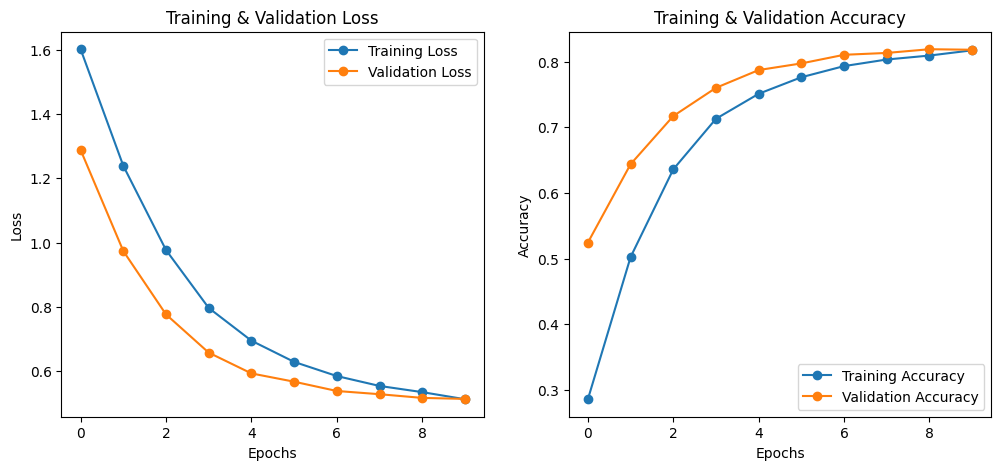

In [20]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a figure with subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

# Show plots
plt.show()


In [21]:
classifier.evaluate(test_dataset)

78/78 [==============================] - 43s 553ms/step - loss: 0.5139 - accuracy: 0.8182


[0.5138771533966064, 0.8181818127632141]

78/78 [==============================] - 46s 542ms/step


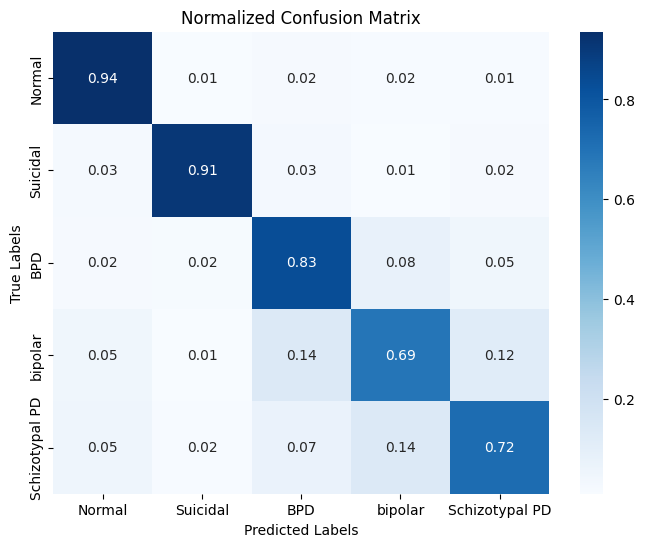

                precision    recall  f1-score   support

        Normal     0.8672    0.9358    0.9002      1012
      Suicidal     0.9448    0.9089    0.9265       999
           BPD     0.7606    0.8310    0.7942       994
       bipolar     0.7274    0.6867    0.7065       948
Schizotypal PD     0.7838    0.7202    0.7507       997

      accuracy                         0.8182      4950
     macro avg     0.8168    0.8165    0.8156      4950
  weighted avg     0.8179    0.8182    0.8170      4950



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
y_true = test_df['label'].values  # True labels
y_pred_probs = classifier.predict(test_dataset)  # Model predictions (probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute normalized confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize row-wise (per class)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=df['status'].unique(), yticklabels=df['status'].unique())

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=df['status'].unique(), digits=4))

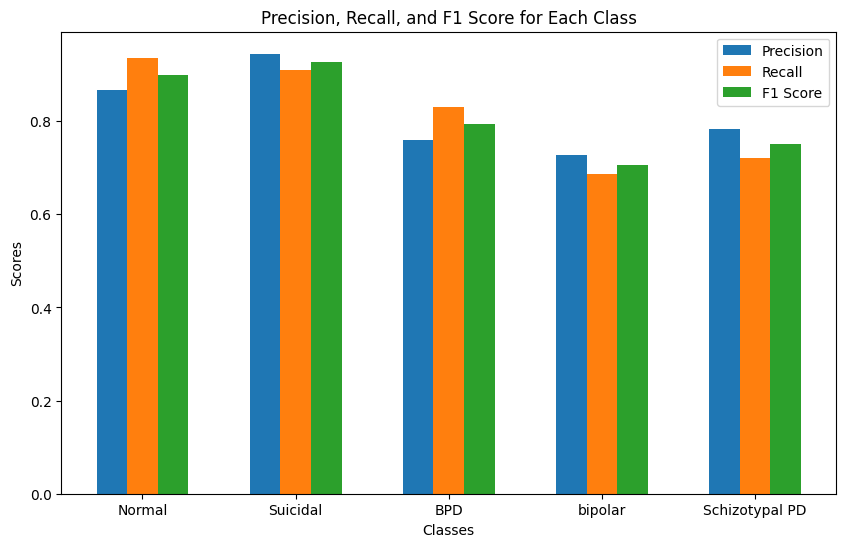

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

classes = df['status'].unique()

plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
width = 0.2

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks(x, classes)
plt.legend()
plt.show()

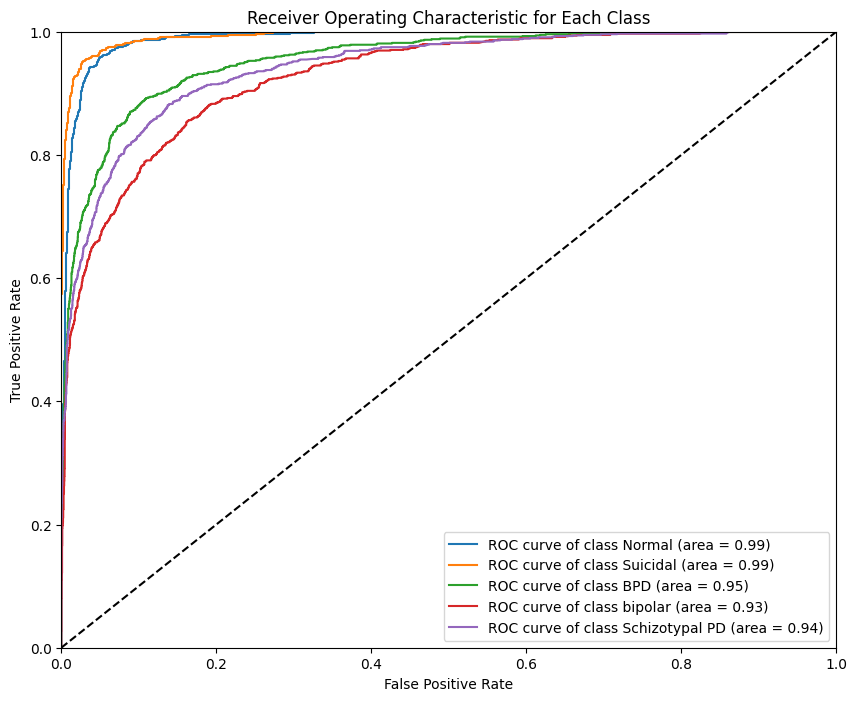

In [25]:
from sklearn.metrics import roc_curve, auc

# Binarize the output
from sklearn.preprocessing import label_binarize
y_true_binarized = label_binarize(y_true, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels from test dataset
y_true = []
y_pred = []

for batch in test_dataset:
    inputs, labels = batch
    predictions = classifier(inputs)  # Get model predictions
    predicted_classes = np.argmax(predictions.numpy(), axis=1)  # Convert to class labels

    y_true.extend(labels.numpy())  # Store actual labels
    y_pred.extend(predicted_classes)  # Store predicted labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[
    "Normal", "Depression", "Suicidal", "Anxiety", "Bipolar", "Stress", "Personality disorder"
])

print(report)

                      precision    recall  f1-score   support

              Normal       0.85      0.92      0.88       755
          Depression       0.97      0.94      0.96      3308
            Suicidal       0.77      0.79      0.78      3016
             Anxiety       0.73      0.73      0.73      2158
             Bipolar       0.77      0.80      0.79       536
              Stress       0.89      0.86      0.87       527
Personality disorder       0.89      0.70      0.78       237

            accuracy                           0.84     10537
           macro avg       0.84      0.82      0.83     10537
        weighted avg       0.84      0.84      0.84     10537



In [26]:
classifier.save_weights("bert_classifier_weights.h5")  # Save weights
tokenizer.save_pretrained("tokenizer")  # Save tokenizer

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [27]:
import pickle

# Save tokenizer to a file
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [28]:
!zip -r /content/tokenizer.zip /content/tokenizer
from google.colab import files
files.download("/content/tokenizer.zip")

  adding: content/tokenizer/ (stored 0%)
  adding: content/tokenizer/tokenizer_config.json (deflated 75%)
  adding: content/tokenizer/vocab.txt (deflated 53%)
  adding: content/tokenizer/tokenizer.json (deflated 71%)
  adding: content/tokenizer/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/bert_classifier_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import numpy as np

# Define label mapping based on your classes
label_map = {
    0: "Normal",
    1: "Suicidal",
    2: "BPD",
    3: "bipolar",
    4: "Schizotypal PD'"
}
# Function to preprocess and predict
def predict(texts):
    # Tokenize the input text
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf", max_length=128)

    # Perform inference
    predictions = classifier(inputs)

    # Get the predicted class
    predicted_class = np.argmax(predictions.numpy(), axis=1)

    # Print results with actual labels
    for text, pred in zip(texts, predicted_class):
        print(f"{text[0:10]} : {label_map[pred]}")

# Example texts for prediction
texts = [
    "Life has been going really well for me lately. I wake up feeling refreshed and excited about the day ahead. Work is engaging, and I enjoy spending time with my friends and family. Even when small challenges come up, I feel confident in handling them. I’ve been practicing mindfulness, exercising regularly, and maintaining a balanced routine, which has really helped me stay positive and grounded.",

    "Lately, everything feels meaningless. No matter what I do, I can’t seem to find any joy in the things I used to love. I feel like I’m stuck in a never-ending cycle of pain, and no one really understands what I’m going through. Every day is just another struggle to get out of bed, and honestly, I don’t see the point anymore. I feel exhausted—physically, emotionally, mentally. It’s like I’m screaming for help, but no one is listening.",

    "I feel like I’m constantly on an emotional rollercoaster. One moment, I’m on top of the world, and the next, I feel completely worthless. My relationships are so intense, and I always worry that people will leave me. Sometimes, I lash out or say things I don’t mean because I get scared of being abandoned. I don’t even know who I really am—my personality seems to change depending on who I’m with.",

    "Some days, I feel incredibly energized, like I can conquer anything. I start new projects, make impulsive decisions, and barely need sleep. But then, without warning, everything shifts. I fall into a deep depression where I can’t even get out of bed. My emotions swing between extreme highs and crushing lows, and it’s exhausting trying to keep up with myself.",

    "I often feel like I don’t belong in this world, like I’m different from everyone else. Sometimes, I have thoughts that don’t seem to be my own, or I feel like I’m watching my life from the outside. People say I come across as strange or distant, but I don’t know how to connect with them in a way that feels natural. It’s as if there’s a wall between me and the rest of the world.",

    "Lately, I’ve been feeling completely overwhelmed. There’s so much to do, and no matter how hard I try, I can’t seem to keep up. The stress keeps piling on, and I’m constantly exhausted. I wish I could just take a break from everything, but I don’t have the time. My responsibilities feel like a never-ending burden, and I don’t know how much longer I can handle it.",

    "Sometimes, I feel like there are different versions of me living inside my mind. One moment, I’m confident and outgoing, and the next, I’m withdrawn and unsure of who I really am. I struggle with my sense of identity, and it feels like I’m constantly shifting between different personalities. It’s confusing and unsettling, and I don’t know how to explain it to anyone else."
]

# Run inference
predict(texts)

Life has b : bipolar
Lately, ev : BPD
I feel lik : BPD
Some days, : BPD
I often fe : Schizotypal PD'
Lately, I’ : BPD
Sometimes, : BPD
